### Geração das máscaras com Grabcut

In [4]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [58]:
def listar_imagens(diretorio_raiz, extensoes_imagens=None):
    if extensoes_imagens is None:
        extensoes_imagens = ['.jpg', '.jpeg', '.png']

    arquivos_imagens = []
    for dirpath, _, filenames in os.walk(diretorio_raiz):
        for filename in filenames:
            if any(filename.lower().endswith(extensao) for extensao in extensoes_imagens):
                caminho_completo = os.path.join(dirpath, filename)
                arquivos_imagens.append(caminho_completo)
    return arquivos_imagens
  
def exibir_imagens(lista_de_caminhos, largura=40, altura=25, path=True):
    num_imagens = len(lista_de_caminhos)
    
    if path:
    
      fig, axes = plt.subplots(1, num_imagens, figsize=(largura, altura))
    
      for i, caminho in enumerate(lista_de_caminhos):

          imagem = Image.open(caminho)
            
          axes[i].imshow(imagem)
          axes[i].axis('off')
          img = caminho.split("/")
          img = img[len(img)-1].replace("\\", " ").replace(".png", "")
          if "for" in img:
            img = img.replace("for intraepithelial lesion", "")
          axes[i].set_title(img)
      plt.show()
    else:
      
      # map_celula = {
      #   "title" : None,
      #   "img-inteira-title": None,
      #   "img-inteira-plotada" : None,
      #   "img" : None,
      #   "img-seg" : None,
      #   "img-mask" : None,
      # }
      fig, axes = plt.subplots(nrows=len(lista_de_caminhos), ncols=3, figsize=(largura, altura))
      plt.subplots_adjust(wspace=0.2)
      
      for i, each in enumerate(lista_de_caminhos):

          
          
          # Plotar imagem segmentada
          axes[i, 1].imshow(each["img-seg"])
          axes[i, 1].axis('off')
          if "for" in each["title"]:
            axes[i, 1].set_title(f'Segmentada  - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 1].set_title(f'Segmentada  - {each["title"]}')
              
          
          # Plotar original
          axes[i, 0].imshow(each["img"])
          axes[i, 0].axis('off')
          
          if "for" in each["title"]:
            
            axes[i, 0].set_title(f'Original - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 0].set_title(f'Original - {each["title"]}')
          # Plotar mask
          
          axes[i, 2].imshow(each["img-mask"])
          axes[i, 2].axis('off')
          if "for" in each["title"]:
            axes[i, 2].set_title(f'Mask - {each["title"].replace("for intraepithelial lesion", "")}')
          else:
            axes[i, 2].set_title(f'Mask - {each["title"]}')
            
      plt.show()

In [61]:
directory_path = '../data/base_recortada/'
images = listar_imagens(directory_path)
exibir_imagens(images)

### GrabCut com imagem já recortada

In [60]:
def remover_fundo_com_grabcut_recortado(imagem):
    mascara = np.zeros(imagem.shape[:2], np.uint8)
    backgroundModel = np.zeros((1, 65), np.float64)
    foregroundModel = np.zeros((1, 65), np.float64)
    altura, largura = imagem.shape[:2]
    
    # Calcular os limites do retângulo
    x1 = 0
    y1 = 0
    x2 = largura - 1
    y2 = altura - 1
        
    rectangle = (x1, y1, x2 - x1, y2 - y1)
    
    print(f"Valor do ratangulo: {rectangle}")
    
    cv2.grabCut(imagem, mascara, rectangle,  
            backgroundModel, foregroundModel,
            3, cv2.GC_INIT_WITH_RECT)
    
    mascara_objeto = np.where((mascara == 2) | (mascara == 0), 0, 1).astype('uint8')
    
    imagem_sem_fundo = imagem * mascara_objeto[:, :, np.newaxis]
    
    img_recortada = imagem_sem_fundo[y1:y2, x1:x2]
    
    imagem_gray = cv2.cvtColor(img_recortada, cv2.COLOR_BGR2GRAY)
    
    _, mascara = cv2.threshold(imagem_gray, 10, 255, cv2.THRESH_BINARY)
    
    img_original_recortada = imagem[y1:y2, x1:x2]
    
    return img_recortada, mascara, img_original_recortada

In [8]:
def paint_quadrado_imagem_recortado(imagem, x_central, y_central):
  altura, largura = imagem.shape[:2]
    
  # Calcular os limites do retângulo
  x1 = 0
  y1 = 0
  x2 = largura - 1
  y2 = altura - 1

  imagem_com_quadrado = imagem.copy()
  cv2.rectangle(imagem_com_quadrado, (x1, y1), (x2, y2), (0, 255, 0), 2)  
  cv2.circle(imagem_com_quadrado, (x_central, y_central), 5, (0, 0, 255), -1) 

  imagem_com_quadrado_rgb = cv2.cvtColor(imagem_com_quadrado, cv2.COLOR_BGR2RGB)
  return imagem_com_quadrado_rgb

In [52]:
def generateMapSegmentad_Recortada(lista_map_celula, info_img):
  # value_expand = 70
  df = pd.read_csv("../data/classifications.csv")
  df = df[df["image_filename"] == f"{info_img}.png"]
  # df = df[df["cell_id"] == int(info_img) ]

  print(df)
  print("--------------\n\n\n")
  map_celula = {
    "title" : None,
    "img-inteira-title": None,
    "img-inteira-plotada" : None,
    "img" : None,
    "img-seg" : None,
    "img-mask" : None,
  }

  

  for i, each in enumerate(df.iterrows()):
    
    
    nome_img = each[1]['image_filename']
    nome_da_doenca = each[1]['bethesda_system']
    id_celular = each[1]['cell_id']  
    
    database = f"../data/base_recortada/{nome_da_doenca}/"
    
    try:
      
    
      path = "".join([database, str(id_celular)]) + ".png"
      print(path)
      imagem = cv2.imread(path)
      altura, largura = imagem.shape[:2]
      posi_x = largura // 2
      posi_y =  altura // 2
      imagem_sem_fundo, mask, img_original_recortada = remover_fundo_com_grabcut_recortado(imagem)
      
      map_celula["img"] = img_original_recortada
      map_celula["title"] = f"{nome_da_doenca} - {id_celular}"
      map_celula["img-inteira-title"] = nome_img
      map_celula["img-seg"] = imagem_sem_fundo
      map_celula["img-mask"] = mask
      
      map_celula["img-inteira-plotada"] =  paint_quadrado_imagem_recortado(imagem, posi_x, posi_y)
      lista_map_celula.append(map_celula.copy())
      # print(i)
      print(nome_da_doenca +  " " + str(id_celular))
    except:
      print(f"Deu erro: {database}")
  return lista_map_celula
  

In [53]:
lista_map_celula_recortada = []

generateMapSegmentad_Recortada(lista_map_celula_recortada, "363b6b00d925e5c52694b8f7b678c53b")

     image_id                        image_filename  \
526       393  363b6b00d925e5c52694b8f7b678c53b.png   
527       393  363b6b00d925e5c52694b8f7b678c53b.png   
528       393  363b6b00d925e5c52694b8f7b678c53b.png   
529       393  363b6b00d925e5c52694b8f7b678c53b.png   
530       393  363b6b00d925e5c52694b8f7b678c53b.png   
531       393  363b6b00d925e5c52694b8f7b678c53b.png   
532       393  363b6b00d925e5c52694b8f7b678c53b.png   
533       393  363b6b00d925e5c52694b8f7b678c53b.png   
534       393  363b6b00d925e5c52694b8f7b678c53b.png   

                        image_doi  cell_id  \
526  10.6084/m9.figshare.12230885      527   
527  10.6084/m9.figshare.12230885      528   
528  10.6084/m9.figshare.12230885      529   
529  10.6084/m9.figshare.12230885      530   
530  10.6084/m9.figshare.12230885      531   
531  10.6084/m9.figshare.12230885      532   
532  10.6084/m9.figshare.12230885      533   
533  10.6084/m9.figshare.12230885      534   
534  10.6084/m9.figshare.12230885  

[{'title': 'LSIL - 527',
  'img-inteira-title': '363b6b00d925e5c52694b8f7b678c53b.png',
  'img-inteira-plotada': array([[[  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [230, 231, 238],
          ...,
          [165, 184, 231],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         ...,
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [234, 236, 253],
          ...,
          [234, 236, 215],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [  0, 255,   0],
          [  0, 255,   0]

In [50]:
exibir_imagens(lista_de_caminhos=lista_map_celula_recortada, largura=40, altura=25, path=False)

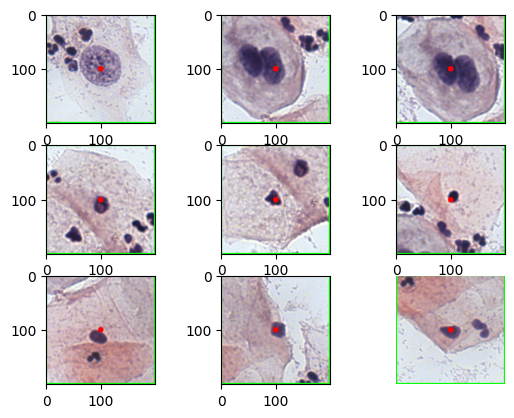

In [54]:

break_line_flag = 2
break_line = 0
break_row = 0
f, axarr = plt.subplots(3,3)

for i, each in enumerate(lista_map_celula_recortada):

  axarr[break_line, break_row].imshow(each.get("img-inteira-plotada"))
  plt.axis('off')
  
  if break_row == break_line_flag:
    break_line += 1
    break_row = 0
  else:
    break_row += 1
    
    
  

In [100]:
lista_map_celula_recortada = []

generateMapSegmentad_Recortada(lista_map_celula_recortada, "0a2a5a681410054941cc56f51eb8fbda")

      image_id                        image_filename  \
5635       164  0a2a5a681410054941cc56f51eb8fbda.png   
5636       164  0a2a5a681410054941cc56f51eb8fbda.png   
5637       164  0a2a5a681410054941cc56f51eb8fbda.png   
5638       164  0a2a5a681410054941cc56f51eb8fbda.png   
5639       164  0a2a5a681410054941cc56f51eb8fbda.png   

                         image_doi  cell_id  \
5635  10.6084/m9.figshare.12230102     5636   
5636  10.6084/m9.figshare.12230102     5637   
5637  10.6084/m9.figshare.12230102     5638   
5638  10.6084/m9.figshare.12230102     5639   
5639  10.6084/m9.figshare.12230102     5640   

                          bethesda_system  nucleus_x  nucleus_y  
5635  Negative for intraepithelial lesion       1012        875  
5636  Negative for intraepithelial lesion        910        900  
5637  Negative for intraepithelial lesion       1177        416  
5638  Negative for intraepithelial lesion       1254        366  
5639                                 LSIL        9

[{'title': 'Negative for intraepithelial lesion - 5636',
  'img-inteira-title': '0a2a5a681410054941cc56f51eb8fbda.png',
  'img-inteira-plotada': array([[[  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [169, 150, 154],
          ...,
          [248, 252, 252],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         ...,
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [200, 200, 208],
          ...,
          [254, 254, 254],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [  0, 255,

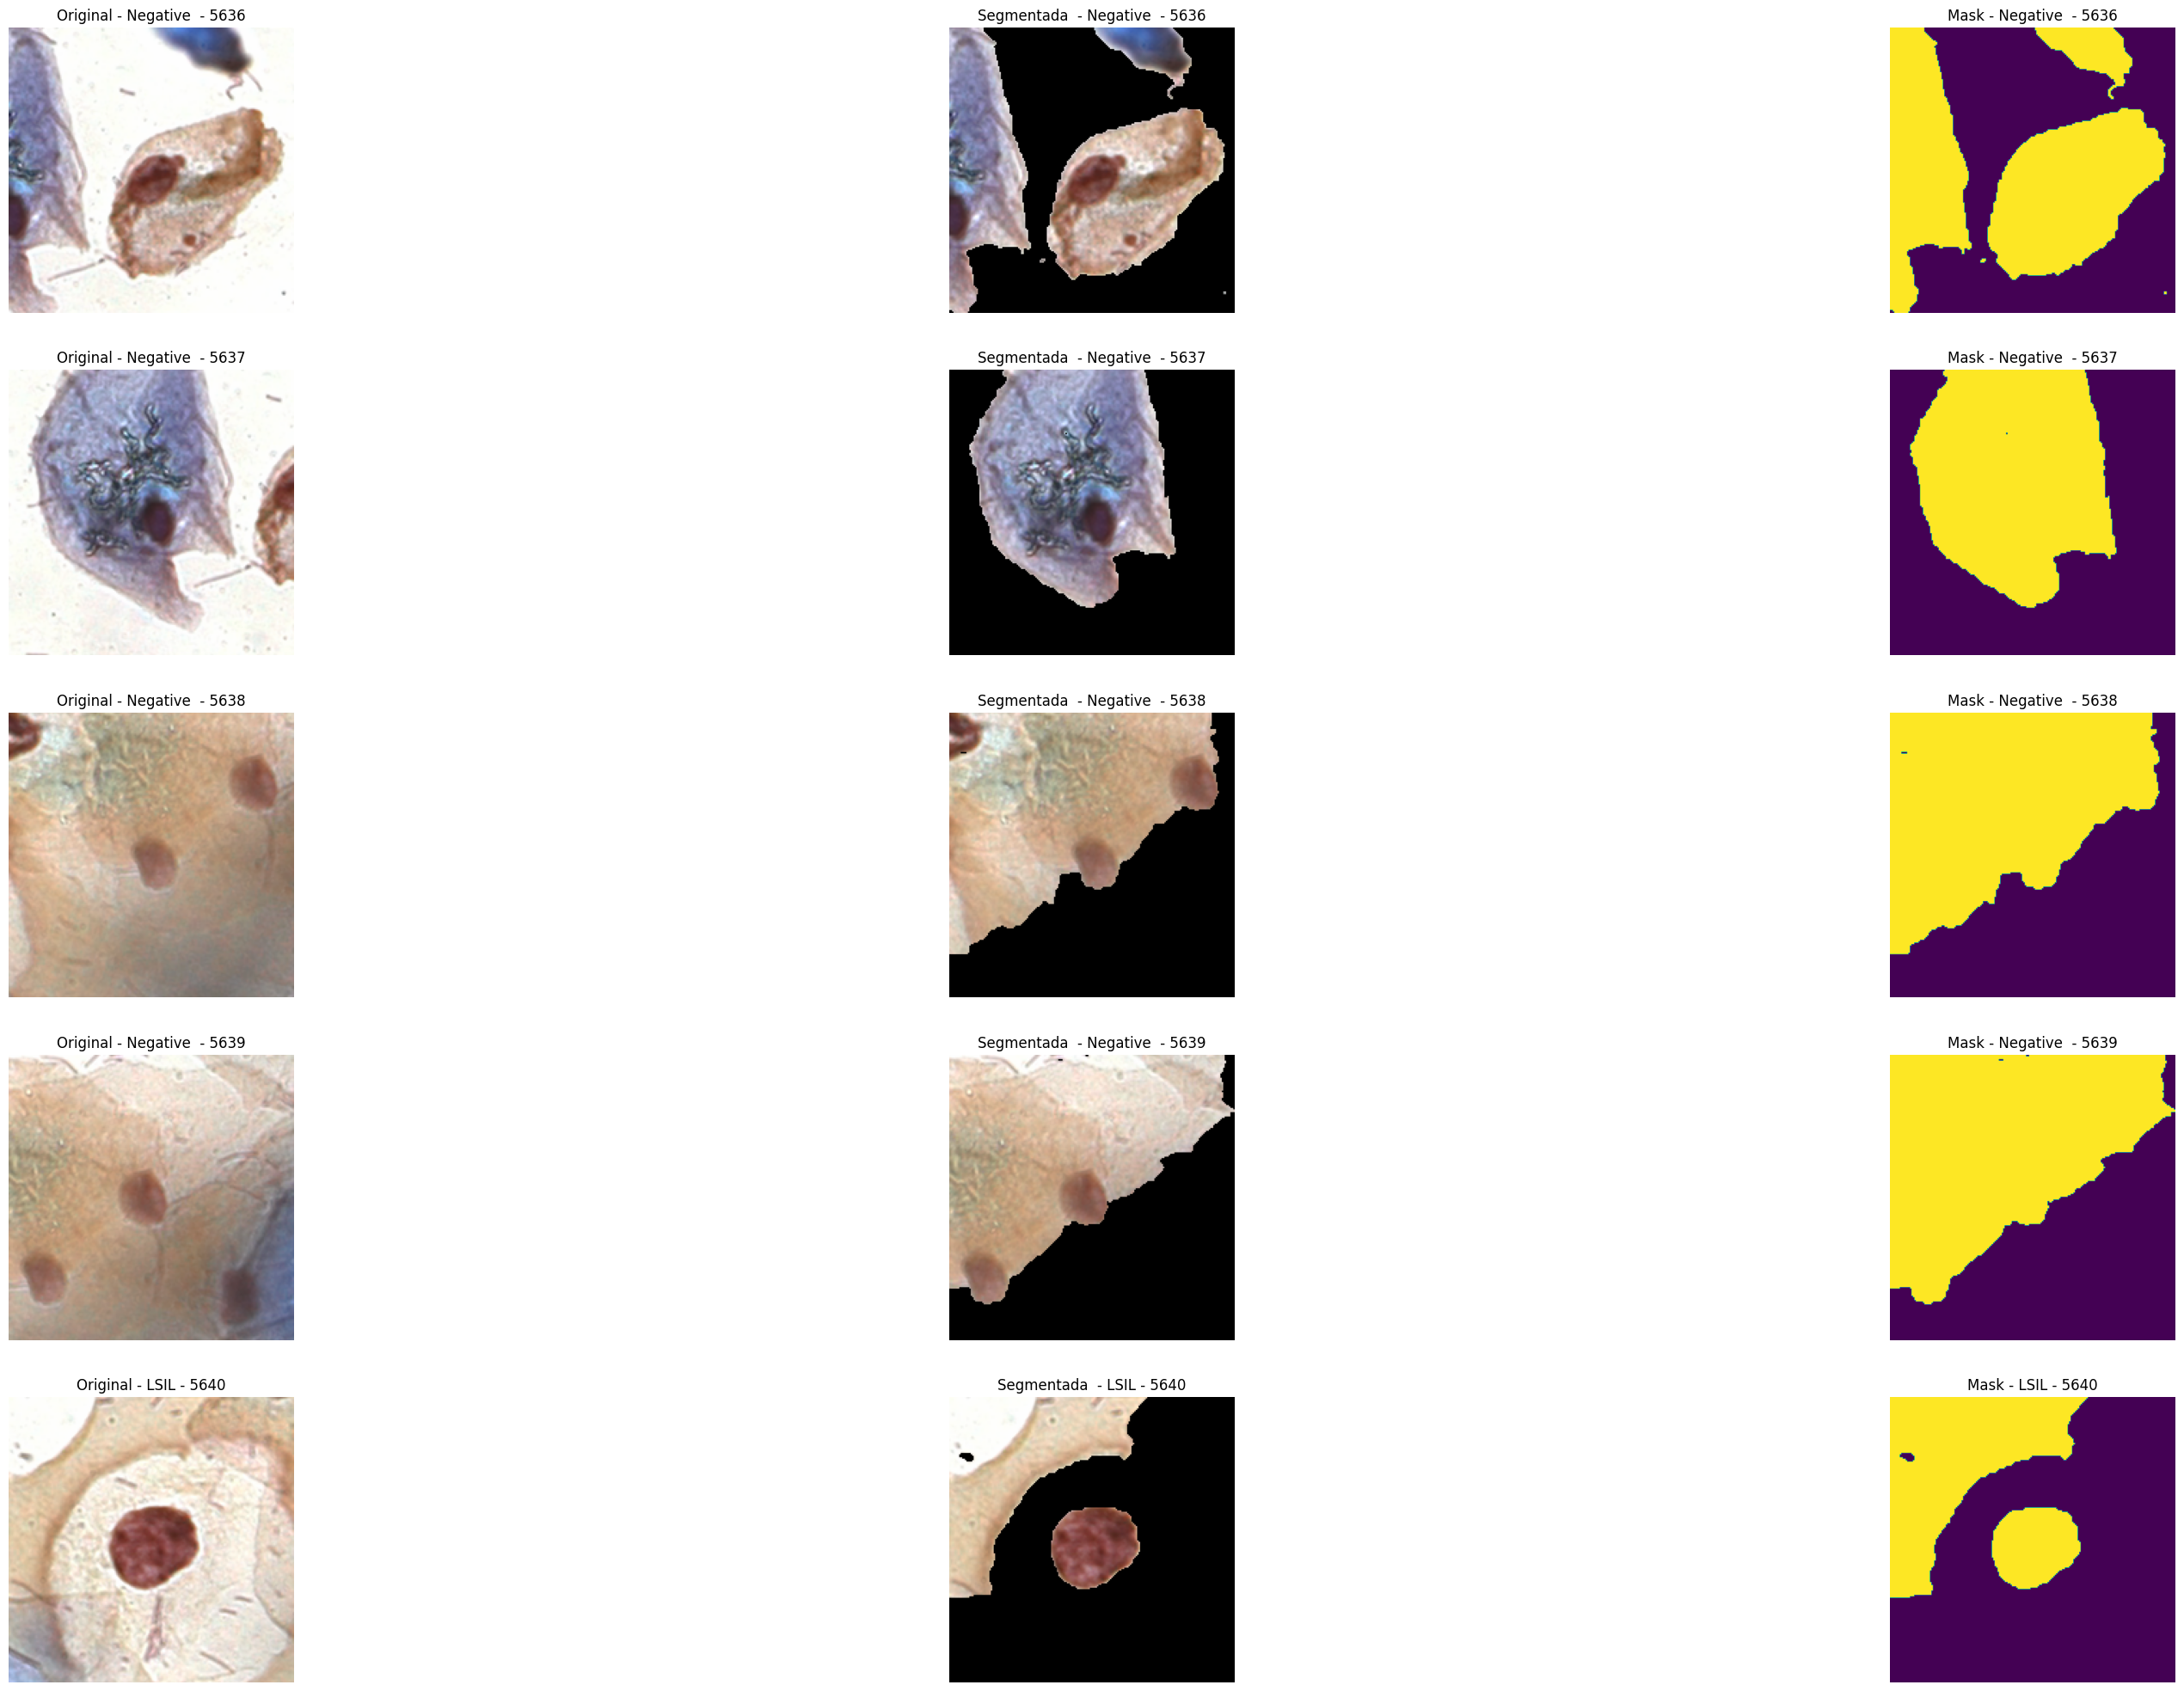

In [101]:
exibir_imagens(lista_de_caminhos=lista_map_celula_recortada, largura=40, altura=25, path=False)

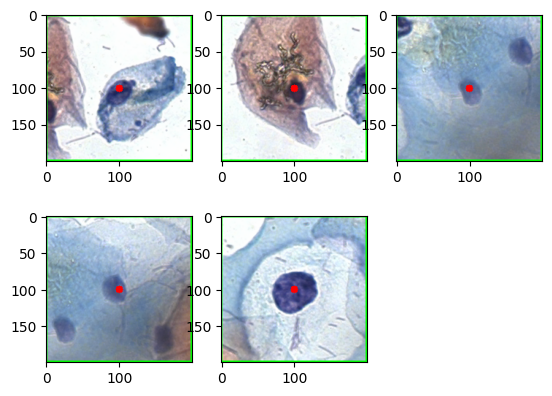

In [114]:
break_line_flag = 2
break_line = 0
break_row = 0



f, axarr = plt.subplots(2,3)

for i, each in enumerate(lista_map_celula_recortada):
 
  axarr[break_line, break_row].imshow(each.get("img-inteira-plotada"))
  plt.axis('off')
    

  if break_row == break_line_flag:
    break_line += 1
    break_row = 0
  else:
    break_row += 1
  
    

In [115]:
lista_map_celula_recortada = []

generateMapSegmentad_Recortada(lista_map_celula_recortada, "1c900ddde4d55e63c0d06c4854b29f89")

      image_id                        image_filename  \
5625       163  1c900ddde4d55e63c0d06c4854b29f89.png   
5626       163  1c900ddde4d55e63c0d06c4854b29f89.png   
5627       163  1c900ddde4d55e63c0d06c4854b29f89.png   
5628       163  1c900ddde4d55e63c0d06c4854b29f89.png   
5629       163  1c900ddde4d55e63c0d06c4854b29f89.png   
5630       163  1c900ddde4d55e63c0d06c4854b29f89.png   
5631       163  1c900ddde4d55e63c0d06c4854b29f89.png   
5632       163  1c900ddde4d55e63c0d06c4854b29f89.png   
5633       163  1c900ddde4d55e63c0d06c4854b29f89.png   
5634       163  1c900ddde4d55e63c0d06c4854b29f89.png   

                         image_doi  cell_id  \
5625  10.6084/m9.figshare.12230099     5626   
5626  10.6084/m9.figshare.12230099     5627   
5627  10.6084/m9.figshare.12230099     5628   
5628  10.6084/m9.figshare.12230099     5629   
5629  10.6084/m9.figshare.12230099     5630   
5630  10.6084/m9.figshare.12230099     5631   
5631  10.6084/m9.figshare.12230099     5632   
5632  1

[{'title': 'Negative for intraepithelial lesion - 5626',
  'img-inteira-title': '1c900ddde4d55e63c0d06c4854b29f89.png',
  'img-inteira-plotada': array([[[  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [234, 175, 165],
          ...,
          [177, 179, 187],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         ...,
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [207, 204, 209],
          ...,
          [249, 254, 254],
          [  0, 255,   0],
          [  0, 255,   0]],
  
         [[  0, 255,   0],
          [  0, 255,   0],
          [  0, 255,   0],
          ...,
          [  0, 255,

In [116]:
exibir_imagens(lista_de_caminhos=lista_map_celula_recortada, largura=40, altura=25, path=False)

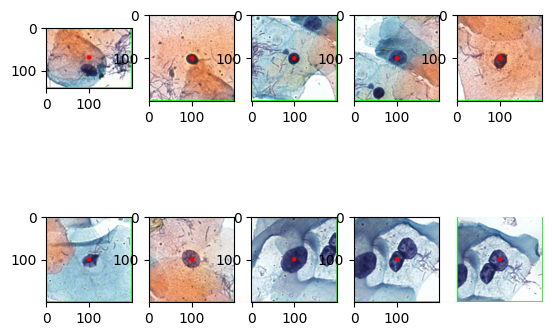

In [121]:
break_line_flag = 4
break_line = 0
break_row = 0



f, axarr = plt.subplots(2,5)

for i, each in enumerate(lista_map_celula_recortada):
 
  axarr[break_line, break_row].imshow(each.get("img-inteira-plotada"))
  plt.axis('off')
    

  if break_row == break_line_flag:
    break_line += 1
    break_row = 0
  else:
    break_row += 1